In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from datetime import timedelta, datetime, date, time

from astropy.time import Time
from astropy import units as u
from poliastro.twobody import Orbit
from poliastro.bodies import Earth, Mars, Sun, Jupiter, Venus
from poliastro.plotting import OrbitPlotter3D, OrbitPlotter2D

import utils.metrics as metrics
import utils.physical_utils
import preprocessing.extra_points_removing as epr
import preprocessing.data_loading as data_loading

In [2]:
df = data_loading.load_train_dataframe()
df_test = data_loading.load_test_dataframe()

df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,Vz_sim,total_seconds,delta_time,orbit,a,ecc,inc,raan,argp,nu
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,-2.024133,0.000,2803.000,26080 x 45421 km x 66.6 deg (GCRS) orbit aroun...,35750.514004,0.270500,1.162389,4.703662,4.188790,7.351826e-17
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,...,-0.616468,2803.000,2803.000,26080 x 45418 km x 66.6 deg (GCRS) orbit aroun...,35748.799206,0.270473,1.162382,4.703637,4.188586,4.665457e-01
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,...,0.718768,5606.001,2803.001,26079 x 45422 km x 66.6 deg (GCRS) orbit aroun...,35750.632657,0.270525,1.162386,4.703614,4.188503,8.948489e-01
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,...,1.718306,8409.001,2803.000,26079 x 45427 km x 66.6 deg (GCRS) orbit aroun...,35753.337417,0.270576,1.162393,4.703602,4.188621,1.266563e+00
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,...,2.342237,11212.002,2803.001,26080 x 45430 km x 66.6 deg (GCRS) orbit aroun...,35755.129047,0.270593,1.162397,4.703597,4.188767,1.582752e+00


Описание полей датасета:
- id - integer measurement id
- epoch — datetime in "%Y-%m-%dT%H:%M:%S.%f” format (like 2014-02-01T00:44:57.685)
- sat_id — integer satellite id
- (x, y, z), (x_sim, y_sim, z_sim)	реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) координаты спутника (км)
- реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) скорости спутника (км / с)

In [3]:
real_columns = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
sim_columns = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']

In [4]:
satellite_true_values = df[real_columns].to_numpy()
satellite_predicted_values = df[sim_columns].to_numpy()

print(metrics.smape(satellite_predicted_values, satellite_true_values))
print(metrics.score(satellite_predicted_values, satellite_true_values))

0.15973600741329672
84.02639925867032


## Сопоставление данных из тестовой и обучающей выборок для одного спутника

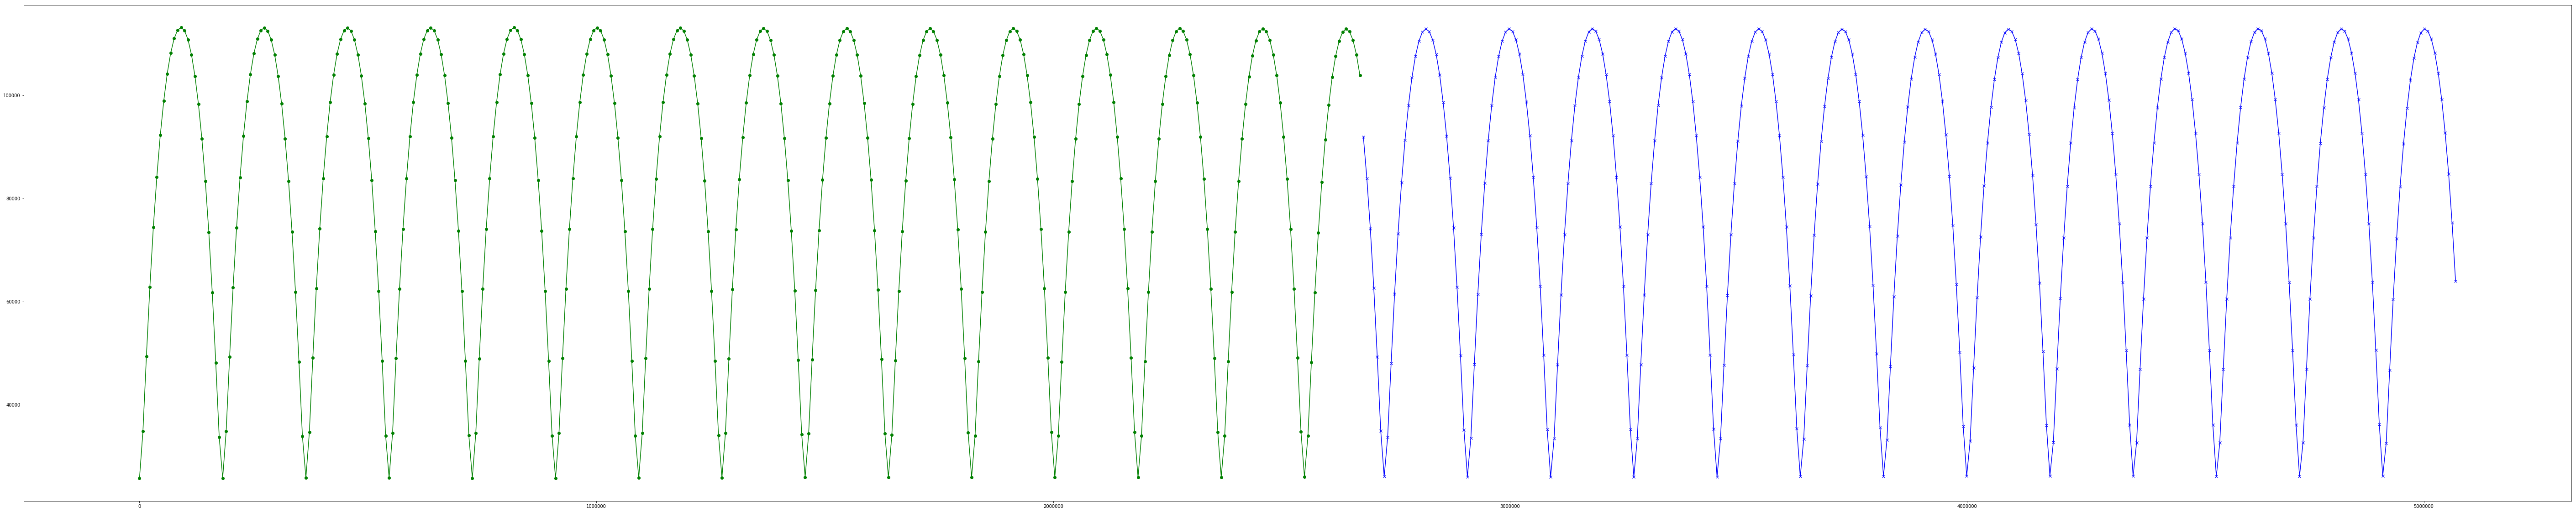

In [7]:
index = 3

plt.figure(figsize = (100, 20))
sat = df[df.sat_id==index]

x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-go')

sat = df_test[df_test.sat_id==index]
x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-bx')

plt.show()

## Визуализация роста ошибки с течением времени

In [8]:
satellite_true_values = df[real_columns].to_numpy()
satellite_predicted_values = df[sim_columns].to_numpy()

df['error'] = np.mean(np.abs((satellite_predicted_values - satellite_true_values)
                                / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))), axis=1)

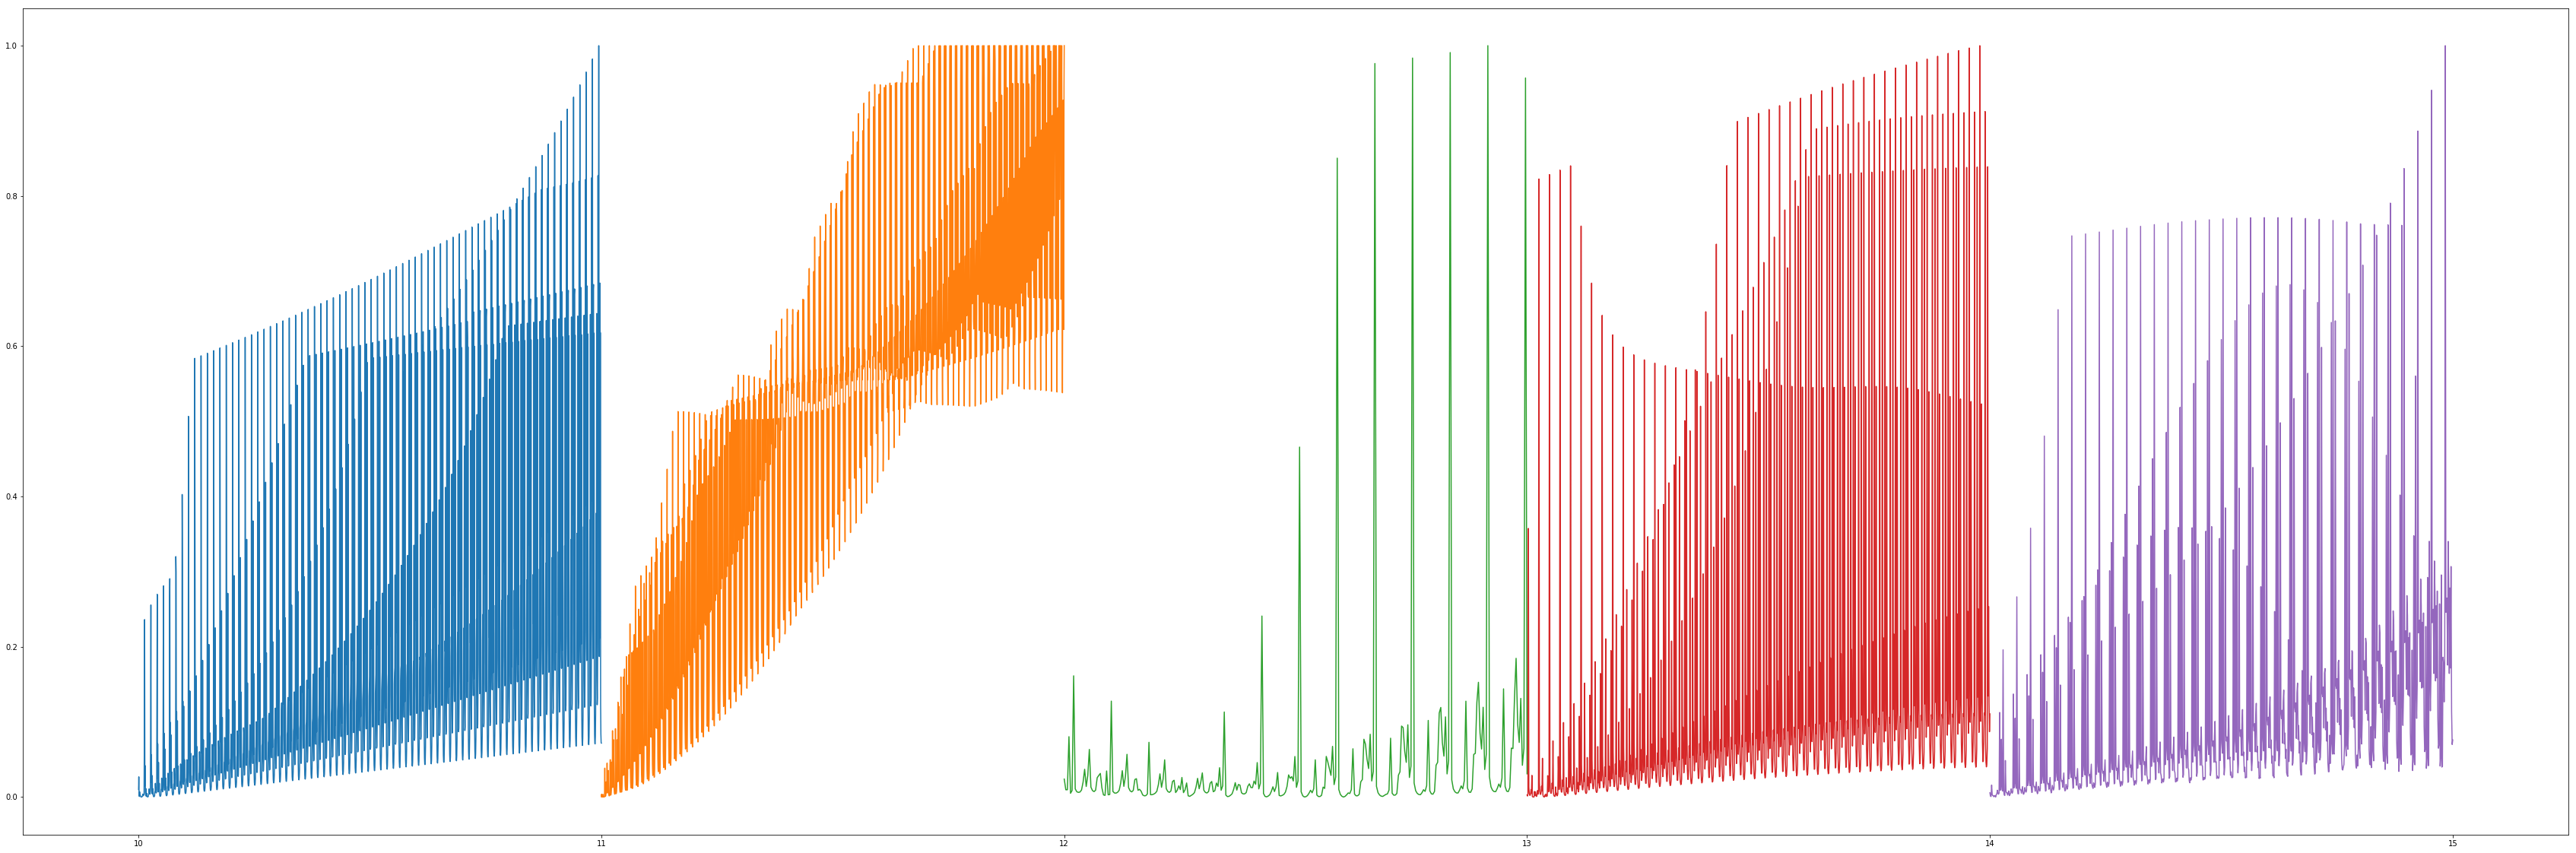

In [9]:
plt.figure(figsize = (60, 20))

for i in range(10,15):
    n = len(df[df['sat_id']==i])
    
    x = np.linspace(1.0 * i, 1.0 * (i+1), num=n)
    
    y = df[df['sat_id']==i]['error']
    y=y-y.min()
    y=y/y.max()
    plt.plot(x,y)
    
plt.show()

## Сопоставление высоты полета спутника и  ошибки

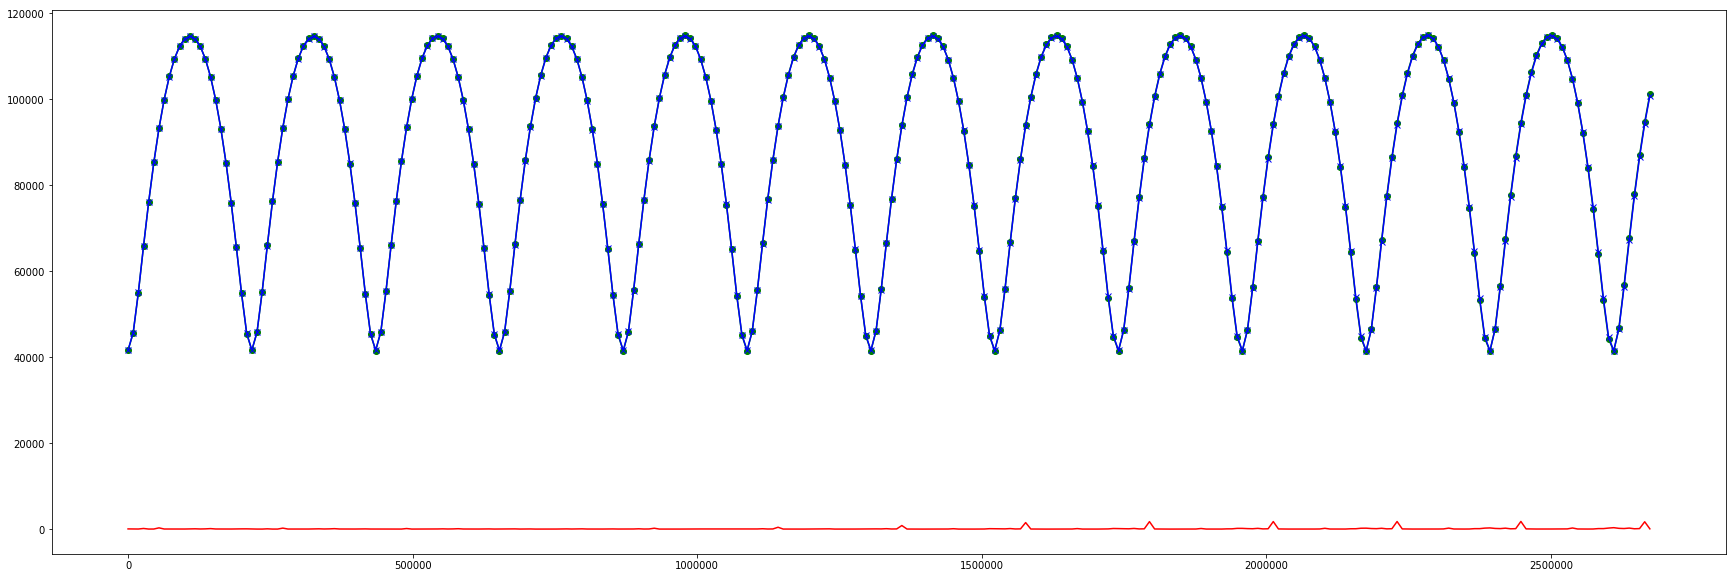

41515.747088490636


In [10]:
plt.figure(figsize = (30, 10))
sat = df[df.sat_id==12]

#x = np.linspace(0.0, 1.0, num=len(sat))
x = sat['total_seconds']

y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
plt.plot(x,y, '-go')

x = sat['total_seconds']
y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y, '-bx')

#x = np.linspace(0.0, sat['total_seconds'].max(), num=len(sat))


plt.plot(x, sat['error']*10000, '-r')

plt.show()
print(y.min())

## Случайно наткнулся на линейную зависимость между средней высотой полета спутника и разбросом его высот, скорее всего это бесполезно для нашей задачи, но я все же хочу изучить этот момент позже

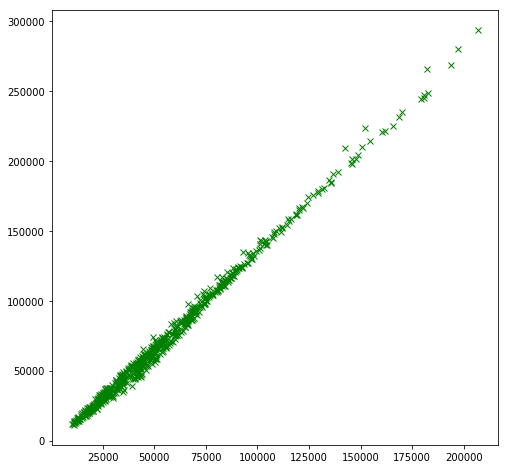

In [412]:
df['h'] = (df.x**2 + df.y**2 + df.z**2)**0.5

h_list = []
y_delta = []

for i in df['sat_id'].unique():
    sat = df[df['sat_id']==i]
    
    h_list.append(np.mean(sat.h))
    y_delta.append(np.max(sat.h))

plt.figure(figsize = (8, 8))

y_delta = np.array(y_delta)
#y_delta=y_delta-y_delta.min()
#y_delta=y_delta/y_delta.max()

plt.plot(h_list,y_delta, 'gx')
    
plt.show()

## Визуализация траектории спутника

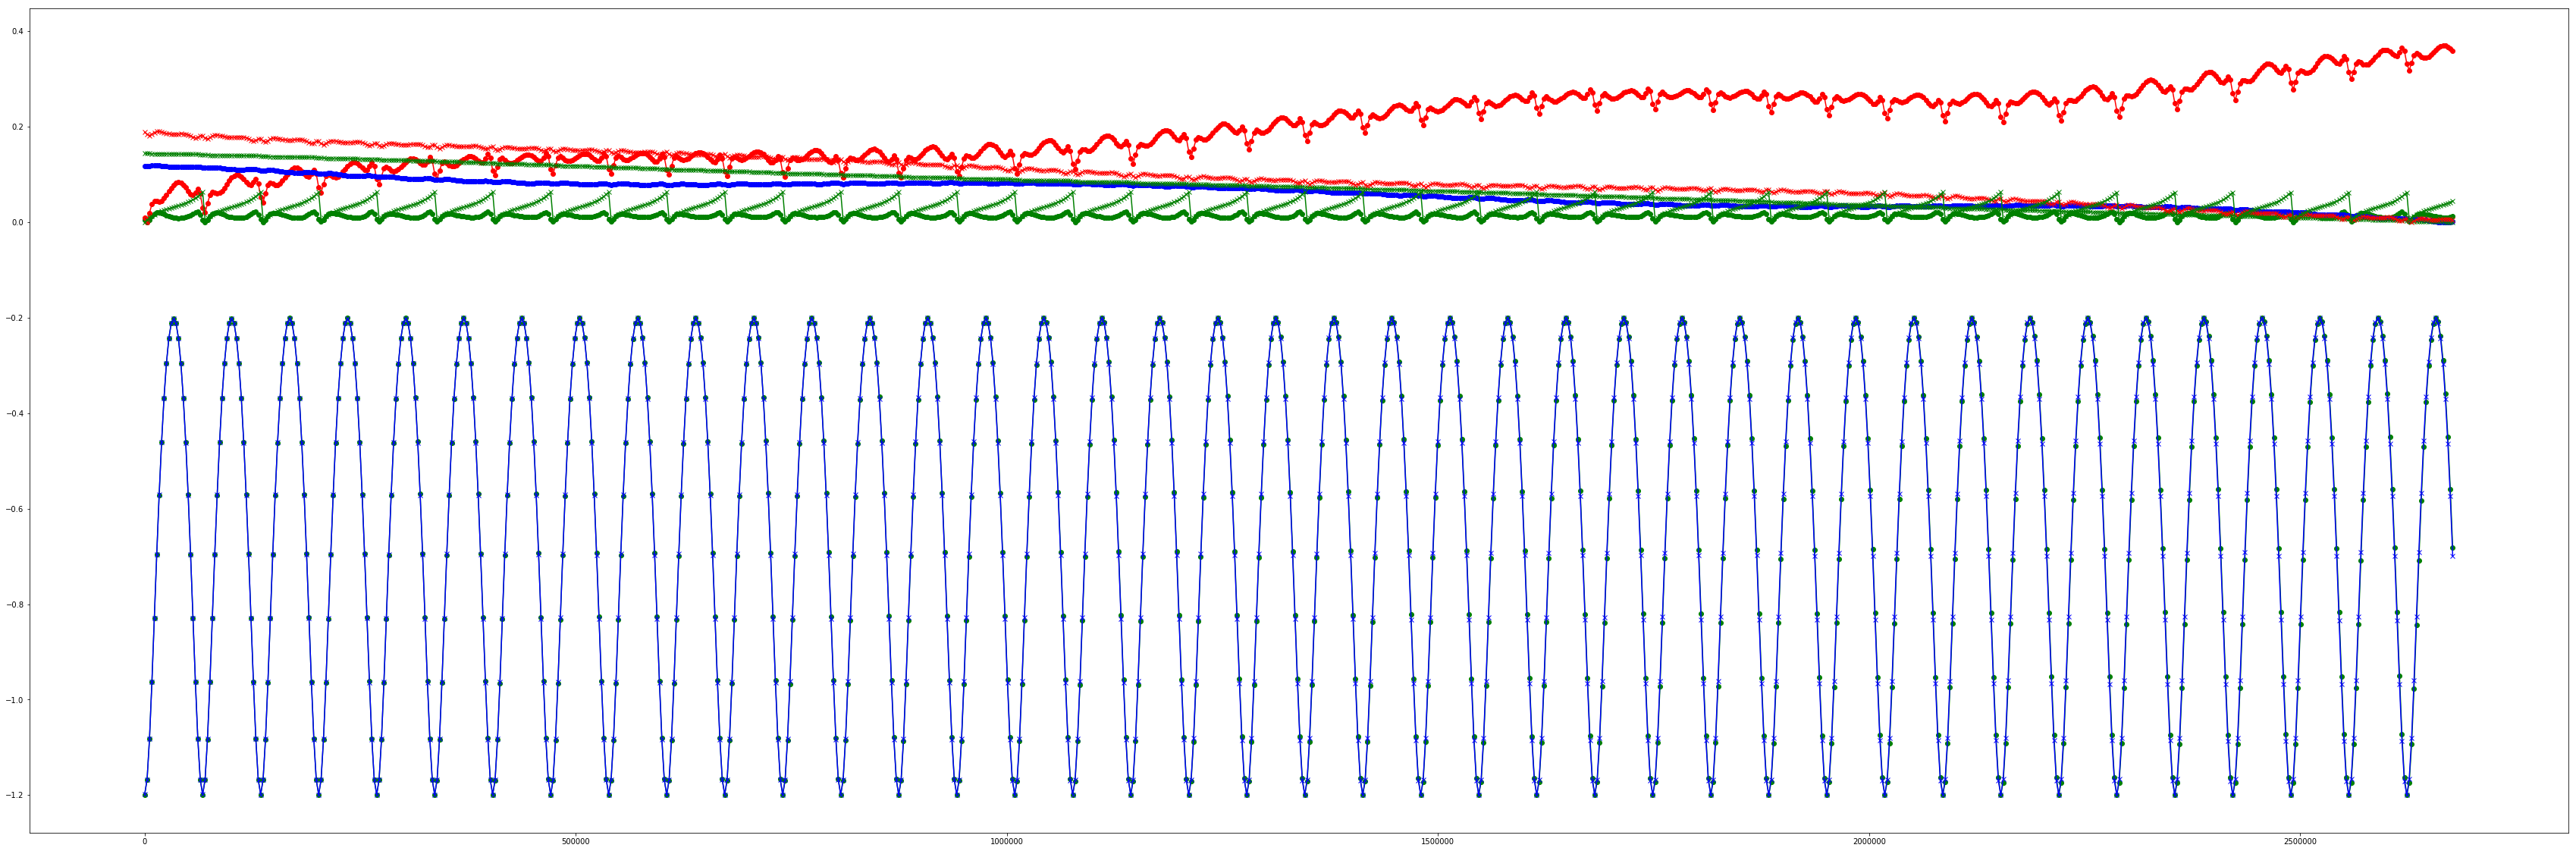

In [394]:
plt.figure(figsize = (60, 20))
sat = df[df.sat_id==0]
k = 100

x = sat['total_seconds']

y = sat['a']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-go')

y = sat['ecc']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-ro')

y = sat['inc']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-bo')

y = sat['raan']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-gx')

y = sat['argp']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-rx')


y=np.arctan2(np.sin(sat['nu']),np.cos(sat['nu']))
y=np.where(y<0 , 2*np.pi+y, y)/100
plt.plot(x,y, '-gx')



y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
y=y-y.min()
y=y/y.max()-1.2
plt.plot(x,y, '-go')

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
y=y-y.min()
y=y/y.max()-1.2
plt.plot(x,y, '-bx')

plt.show()

# Тест предсказания из последенй позиции

In [15]:
orbits = []
for i in range(600):
    sat = df[df['sat_id']==i].iloc[-1]
    
    ss = physical_utils.get_orbit_from_orbital_elements(sat[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']], sat['total_seconds'])
    ss = ss.propagate(-sat['total_seconds'] * u.s)
    orbits.append(ss)

In [16]:
df_test = pd.read_csv("data/test.csv")
df_test['epoch'] = df_test.epoch.map(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
df_test['total_seconds'] = df_test.epoch.map(lambda x: (x - datetime(2014, 1, 1)).total_seconds())
df_test.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,total_seconds
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0.000
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2803.000
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,5606.001
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,8409.001
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,11212.002


In [17]:
lambdafunc = lambda r: pd.Series(list(np.reshape(np.array( orbits[r['sat_id']].propagate(r['total_seconds'] * u.s).rv() ), 6)))

df_test[sim_columns] = df_test.apply(lambdafunc, axis=1)

In [615]:
submission = pd.read_csv("data/submission.csv")

submission[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]=df_test[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
submission.to_csv("data/output_submission.csv",index=False,sep=',')